In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

<AxesSubplot: >

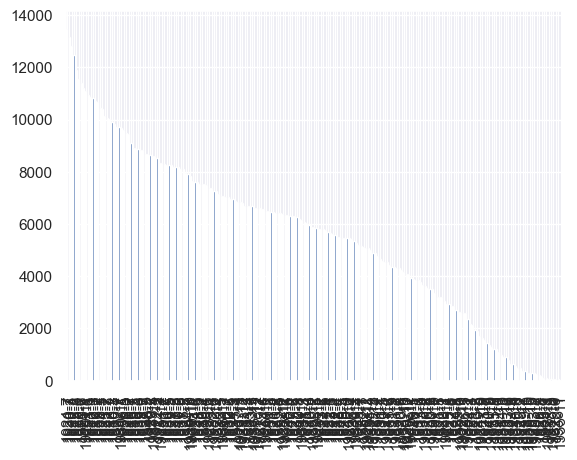

In [79]:
df = pd.read_csv('urls.csv',header=None,names=['yr','month','day','title','url'],low_memory=True)
fig, ax = plt.subplots()
df['yr-month'] = df[["yr", "month"]].astype(str).apply("-".join, axis=1)
df['yr-month'].value_counts().plot(ax=ax, kind='bar')

In [14]:
df = pd.read_csv('uk_parliament_articles.csv',delimiter=';')

EmptyDataError: No columns to parse from file

In [13]:
df.head()

,ID,Title,Date,Text
0,0,Preamble,16 January 1940,HC Deb 16 January 1940 vol 356 c1 §\nThe House...
1,1,DEATH OF A MEMBER.,16 January 1940,HC Deb 16 January 1940 vol 356 c1 §\n M...
2,2,PRIVATE BUSINESS.,16 January 1940,HC Deb 16 January 1940 vol 356 c1
3,3,ABERDEEN CORPORATION (ADMINISTRATION FINANCE E...,16 January 1940,HC Deb 16 January 1940 vol 356 c1 §\n C...
4,4,ORAL ANSWERS TO QUESTIONS.,16 January 1940,HC Deb 16 January 1940 vol 356 cc1-21


In [19]:
df_per_year = df[df['yr'] == 1920]



uniq_months = set(df_per_year['month'])
for mon in uniq_months:
    input = [[row['yr'],row['month'],row['day'],row['title'],row['url']] for _, row in df_per_year[df_per_year['month'] == mon].iterrows()]
    print(input)
    break



[[1920, 2, 10, 'Preamble', 'https://api.parliament.uk/historic-hansard/commons/1920/feb/10/preamble'], [1920, 2, 10, 'WARRANTS FOR NEW WRITS.', 'https://api.parliament.uk/historic-hansard/commons/1920/feb/10/warrants-for-new-writs'], [1920, 2, 10, 'NEW MEMBERS SWORN.', 'https://api.parliament.uk/historic-hansard/commons/1920/feb/10/new-members-sworn'], [1920, 2, 10, 'NEW WRIT.', 'https://api.parliament.uk/historic-hansard/commons/1920/feb/10/new-writ'], [1920, 2, 10, 'SESSIONAL ORDERS.', 'https://api.parliament.uk/historic-hansard/commons/1920/feb/10/sessional-orders'], [1920, 2, 10, 'ELECTIONS.', 'https://api.parliament.uk/historic-hansard/commons/1920/feb/10/elections'], [1920, 2, 10, 'WITNESSES.', 'https://api.parliament.uk/historic-hansard/commons/1920/feb/10/witnesses'], [1920, 2, 10, 'METROPOLITAN POLICE.', 'https://api.parliament.uk/historic-hansard/commons/1920/feb/10/metropolitan-police'], [1920, 2, 10, 'VOTES AND PROCEEDINGS.', 'https://api.parliament.uk/historic-hansard/comm

In [16]:
df_per_year 

[[1920,
  2,
  10,
  'Preamble',
  'https://api.parliament.uk/historic-hansard/commons/1920/feb/10/preamble'],
 [1920,
  2,
  10,
  'WARRANTS FOR NEW WRITS.',
  'https://api.parliament.uk/historic-hansard/commons/1920/feb/10/warrants-for-new-writs'],
 [1920,
  2,
  10,
  'NEW MEMBERS SWORN.',
  'https://api.parliament.uk/historic-hansard/commons/1920/feb/10/new-members-sworn'],
 [1920,
  2,
  10,
  'NEW WRIT.',
  'https://api.parliament.uk/historic-hansard/commons/1920/feb/10/new-writ'],
 [1920,
  2,
  10,
  'SESSIONAL ORDERS.',
  'https://api.parliament.uk/historic-hansard/commons/1920/feb/10/sessional-orders']]

In [32]:
import csv
from bs4 import BeautifulSoup as bs
from dateparser.search import search_dates
import urllib.request as ur
from threading import Thread
import pandas as pd

In [21]:
def get_response_from_url(url,timeout=10,retries=10):
    response = None
    if retries == 0:
        return response # Cannot retry anomore
    try:
        from random import randint
        from time import sleep
        sleep(randint(10,100))
        response = urllib.request.urlopen(url).read().decode('utf-8')
    except HTTPError as error:
        logging.error('HTTP Error: Data of not retrieved because %s\nURL: %s', error, url)
    except URLError as error:
        if isinstance(error.reason, timeout):
            logging.error('Timeout Error: Data of %s not retrieved because %s\nURL: %s',error, url)
            logging.info('Retrying %s after sleeping with %d retries\n' % (url,retries))
            sleep(randint(10,100))
            get_response_from_url(url,timeout,retries - 1)
        else:
            logging.error('URL Error: Data not retrieved because %s\nURL: %s', error, url)
    else:
        logging.info('Access successful.')
    return response

In [35]:
def get_data_from_url(url):
    """Given a url will extract the content from it"""
    print('res start')
    res = get_response_from_url(url)
    print('res end')
    if res == None:
        print('No Response, Skipping %s...' % url)
    soup = bs(res,features='html.parser')
    soup = soup.find("div", {"id": "content"})
    date_section=soup.find('cite',attrs={'class':'section'})
    date = None
    dates = search_dates(date_section.text)
    if len(dates) >= 1: date = dates[0][0]
    contents = soup.findAll(['cite','p'])
    # cite has the speaker name, p has the dialogue
    article_text = ''
    paragraph = list()
    for content in contents:
        paragraph.append(content.text.lstrip())
    article_text += ' '.join(paragraph)
    return {'date':date, 'text':article_text}

In [50]:
test_url = 'https://api.parliament.uk/historic-hansard/commons/1920/feb/10/journal'

In [51]:
res = get_response_from_url(test_url)

In [70]:
import re
def format_text(text):
    pat1 = r'\n'
    pat2 = r'\t'
    pat3 = r'§'
    pat4 = r'[ \t]{2,}'
    patterns = [pat1,pat2,pat3,pat4]
    combined_pat = r'|'.join(patterns)
    text = re.sub(combined_pat, '', text)
    return text

In [71]:
if res == None:
    print('No Response, Skipping %s...' % url)
    return None
soup = bs(res,features='html.parser')
soup = soup.find("div", {"id": "content"})
date_section=soup.find('cite',attrs={'class':'section'})
date = None
dates = search_dates(date_section.text)
if len(dates) >= 1: date = dates[0][0]
contents = soup.findAll(['cite','p'])
text = []
for content in contents:
    if re.search(r' %s ' % date,content.text): continue # skip date section
    text.append(content.text)
article_text = ' '.join(text)
article_text = format_text(article_text)
article_text

'Ordered, That the Journal of this House, from the end of the last Session to the end of the present Session, with an Index thereto, be printed.Ordered, That the said Journal and Index be printed by the appointment and under the direction of Sir Courtenay Peregrine Ilbert, G.C.B.,K.C.S.I.,C.I.E., the Clerk of this House.Ordered, That the said Journal and Index be printed by such person as shall be licensed by Mr. Speaker, and that no other person do presume to print the same.'

In [2]:
articles_df = pd.read_csv('parliament_articles_1925.csv',low_memory=True,delimiter=';')

In [7]:
articles_df['Date'] = pd.to_datetime(articles_df['Date'])
df = pd.read_csv('urls.csv',header=None,names=['yr','month','day','title','url'],low_memory=True)


In [11]:
articles_df[articles_df['Date'].dt.month == 2 and articles_df['Date'].dt.day == 10]

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [12]:

df = pd.read_csv('urls.csv',header=None,names=['yr','mont

SyntaxError: unterminated string literal (detected at line 1) (882535994.py, line 1)

In [13]:
df = pd.read_csv('urls.csv',header=None,names=['yr','month','day','title','url'],low_memory=True)

In [15]:
df['Url'] = str()

In [102]:
articles_df = pd.read_csv('parliament_articles_1925x.csv',low_memory=True,delimiter=';')
articles_df['Date2'] = pd.to_datetime(articles_df['Date'])
articles_df['Url'] = None
for i, row in articles_df.iterrows():
    d = row['Date2']
    t = row['Title']
    t = t.replace('"', r'\"')
    s = 'month == %d & day == %d & yr == %d & title == "%s" ' % (d.month,d.day,d.year,t)
    ans = df.query(s)
    if len(ans) == 0:
        print(row)
        print('-------')
    else:
        articles_df.at[i, 'Url'] = ans.iloc[0]['url']
articles_df = articles_df.drop('Date2', axis=1)
column_to_move = articles_df.pop("Url")
# insert column with insert(location, column_name, column_value)
articles_df.insert(2, 'Url', column_to_move)

ID                        32
Title          UNEMPLOYMENT.
Date                    1925
Text                     NaN
Date2    1925-01-01 00:00:00
Url                     None
Name: 1517, dtype: object
-------
ID                                                      35
Title                                             STEPNEY.
Date                                                  1925
Text     Mr. SCURR asked the Minister of Labour how man...
Date2                                  1925-01-01 00:00:00
Url                                                   None
Name: 1520, dtype: object
-------
ID                                                       6
Title                                              BRICKS.
Date                                                  1925
Text     Mr. SCURR asked the Minister of Health whether...
Date2                                  1925-01-01 00:00:00
Url                                                   None
Name: 1691, dtype: object
-------


In [96]:
column_to_move = articles_df.pop("Url")
# insert column with insert(location, column_name, column_value)
articles_df.insert(2, 'Url', column_to_move)

In [103]:
articles_df.head()

,ID,Title,Url,Date,Text
0,1,Preamble,https://api.parliament.uk/historic-hansard/lor...,10 February 1925,The House met at a quarter past four of the cl...
1,2,ELECTRICITY SPECIAL ORDERS.,https://api.parliament.uk/historic-hansard/lor...,10 February 1925,THE FIRST COMMISSIONER OF WORKS (VISCOUNT PEEL...
2,3,CONSOLIDATION BILLS.,https://api.parliament.uk/historic-hansard/lor...,10 February 1925,"LORD MUIR MACKENZIE My Lords, I beg to move th..."
3,4,THE ŒCUMENICAL PATRIARCHATE.,https://api.parliament.uk/historic-hansard/lor...,10 February 1925,THE LORD ARCHBISHOP OF CANTERBURY had given No...
4,5,BUSINESS OF THE HOUSE.,https://api.parliament.uk/historic-hansard/lor...,10 February 1925,"VISCOUNT HALDANE My Lord, can the noble Marque..."


In [104]:
articles_df.to_csv('parliament_articles_1925.csv', sep=';',index=False)

In [105]:
articlesw_df = pd.read_csv('parliament_articles_1925.csv',low_memory=True,delimiter=';',usecols=['Url'])

In [109]:
res = articlesw_df[articlesw_df['Url'] == 'https://api.parliament.uk/historic-hansard/lords/1925/feb/10/preamble']


4